# Fully Connected NN (Question 1b)

In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
from collections import OrderedDict

# Import Data

## download data

In [2]:
data_path = '../dataset/cifar10'
cifar10     = datasets.CIFAR10(data_path, train=True , download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
cifar10_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
sample_image = 45

## get std deviation and mean

In [4]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.ToTensor())

In [5]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [6]:
data_mean = imgs.view(3, -1).mean(dim=1)
data_std  = imgs.view(3, -1).std(dim=1)

print(f'mean = {data_mean}')
print(f'std = {data_std}')

mean = tensor([0.4914, 0.4822, 0.4465])
std = tensor([0.2470, 0.2435, 0.2616])


## clear memory

In [7]:
# to save memory
del cifar10, cifar10_val, tensor_cifar10, imgs
try:
    cifar10[0]
    print("not deleted")
except:
    print("deleted")

deleted


## real import  

In [8]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, # mean of entire dataset
                             data_std) # std deviation of entire dataset
    ]))

In [9]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)
    ]))

## Verify Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


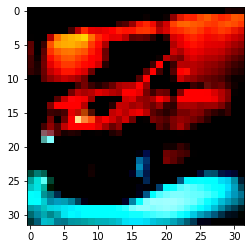

torch.Size([3, 32, 32])


3072

In [10]:
img, label = cifar10[sample_image]

plt.imshow(img.permute(1, 2, 0))
plt.show()

print(img.shape)
torch.numel(img)

# multi-layered NN
part b

## Setup

In [11]:
n_in = torch.numel(img)  # Number of elements in 3 x 32 x 32 image
                         # IE.  3072
n_out = len(cifar10_map) # number of possible outputs
                         # IE.  10

n_inner_1 = n_in // 3
n_inner_2 = n_inner_1 // 2
n_inner_3 = n_inner_2 // 2


model = nn.Sequential(OrderedDict([
        (
        "input_layer",
        nn.Linear(n_in, n_inner_1)
        ),
        (
        "hidden_activation_1",
        nn.Tanh()
        ),
        (
        "hidden_layer_1",
        nn.Linear(n_inner_1, n_inner_2)
        ),
        (
        "hidden_activation_1",
        nn.Tanh()
        ),
        (
        "hidden_layer_2",
        nn.Linear(n_inner_2, n_inner_3)
        ),
        (
        "hidden_activation_1",
        nn.Tanh()
        ),
        (
        "output",
        nn.Linear(n_inner_3, n_out)
        )
    ]))
model

Sequential(
  (input_layer): Linear(in_features=3072, out_features=1024, bias=True)
  (hidden_activation_1): Tanh()
  (hidden_layer_1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden_layer_2): Linear(in_features=512, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [12]:
loss = nn.CrossEntropyLoss()

## setup test

In [13]:
img, label = cifar10[sample_image]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(2.2498, grad_fn=<NllLossBackward0>)

## training function

In [14]:
import time

def training(training_imgs, loss_fn, optimizer, n_epochs:int, report_period:int = 10):
    for epoch in range(n_epochs):
        start = time.time()
        
        for img, label in training_imgs:
            out = model(img.view(img.shape[0], -1))
            loss = loss_fn(out, label)
                    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        end = time.time()
        if ((epoch % report_period) == 0) or (epoch == n_epochs):
            print(f"Epoch: {epoch}, Loss: {float(loss):.5f}, Time: {end-start:.2f} s")

## training

In [17]:
train_loader = torch.utils.data.DataLoader(
                    cifar10, 
                    batch_size=64,
                    shuffle=True
                    )

learning_rate = 1e-2

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss = nn.CrossEntropyLoss()

n_epochs = 300

model

Sequential(
  (input_layer): Linear(in_features=3072, out_features=1024, bias=True)
  (hidden_activation_1): Tanh()
  (hidden_layer_1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden_layer_2): Linear(in_features=512, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [18]:
training(train_loader, 
         loss, 
         optimizer, 
         n_epochs,
         report_period=5
         )

Epoch: 0, Loss: nan, Time: 32.12 s


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))
print("Total:", total)

In [ ]:
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))
print("Total:", total)